In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.special import gamma as sp_gamma # Import gamma from scipy.special
from scipy.interpolate import interp1d, PchipInterpolator
from scipy.optimize import brentq
import cmath # Import cmath for complex number functions

In [2]:
# Initial radial grid
def R_1s(r):
    return (2) * np.exp(- r)

# Exchange (local)

def hs_exchange_potential(rho):
    return -6.0 * ((3 / (8 * np.pi)) * rho) ** (1 / 3)


# Hartree potential

def hartree_potential(r, rho):
    dr_local = r[1] - r[0]
    integral_inner = np.cumsum(4*np.pi*rho*r**2) * dr_local
    integral_outer = np.cumsum((4*np.pi*rho*r)[::-1]) * dr_local
    integral_outer = integral_outer[::-1]
    return integral_inner / np.maximum(r, 1e-12) + integral_outer


# Effective potential

def build_effective_potential(Z, r, rho):
    Vc = -Z / np.maximum(r, 1e-12)
    Vx = hs_exchange_potential(rho)
    Vh = hartree_potential(r, rho)
    return Vc + Vh + Vx


# Radial Schrödinger equation

def radial_eq(r, y, l, E, Vint):
    u, du = y
    V = Vint(r)
    d2u = 2 * (V - E) * u + l * (l + 1) / r**2 * u
    return [du, d2u]


In [3]:
r_bd = np.linspace(1e-5, 15.0, 10_000)

def find_energy_bracket(shoot, Emin, Emax, nscan=2000):
    Egrid = np.linspace(Emin, Emax, nscan)
    fvals = np.array([shoot(E) for E in Egrid])

    for i in range(len(Egrid) - 1):
        if fvals[i] * fvals[i + 1] < 0:
            return Egrid[i], Egrid[i + 1]

    raise RuntimeError("No bound state found in energy interval.")

# Bound-state

def solve_bound_state(Z, r, l, rho, Emin=-3.0, Emax=-0.1):
    def shoot(E):
        u0 = r[0] ** (l + 1)
        du0 = (l + 1) * r[0] ** l

        sol = solve_ivp(
            radial_eq,
            (r[0], r[-1]),
            [u0, du0],
            t_eval=[r[-1]],   # only need endpoint
            rtol=1e-9,
            atol=1e-11,
            args=(l, E, Vint),
        )
        return sol.y[0][-1]  # u(r_max)

    V = build_effective_potential(Z, r, rho)
    Vint = interp1d(r, V, kind="cubic", fill_value="extrapolate")

    # --- find eigenenergy ---
    E1, E2 = find_energy_bracket(shoot, Emin, Emax)
    E = brentq(shoot, E1, E2)

    # --- now integrate fully with correct E ---
    sol = solve_ivp(
        radial_eq,
        (r[0], r[-1]),
        [r[0] ** (l + 1), (l + 1) * r[0] ** l],
        t_eval=r,
        rtol=1e-9,
        atol=1e-11,
        args=(l, E, Vint),
    )

    u = sol.y[0]

    # normalize
    R = u/r
    R /= np.sqrt(np.trapezoid((r*R)**2, r))
    u = R*r

    rho_new = 2 * (R**2) / (4*np.pi)
    #rho_new /= np.trapezoid(4 * np.pi * r**2 * rho_new, r)

    return E, R, rho_new

# He density to build potentials

rho0 = 2 * (R_1s(r_bd))**2 / (4 * np.pi)
while True:
  Eion, R_bd_scf, rho_calc = solve_bound_state(
      Z=2,
      r=r_bd,
      l=0,
      rho=rho0,
      Emin=-3.0,
      Emax=-1.0
  )
  print(Eion)
  if np.absolute(rho_calc - rho0).max() < 1e-6:
    rho_bd = rho_calc
    break
  else:
    rho0 = rho_calc # Update rho0 with the calculated density


-1.9766976197147181
-1.6102958116469868
-1.5897649526638076
-1.5893527923101827
-1.5893409640112772
-1.5893408915165312
-1.5893409886178471
-1.5893407216099622


/tmp/ipython-input-3082205427.py:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  R_init /= np.sqrt(np.trapz((r_grid*R_init)**2, r_grid))


Integration produced 100000 points (requested 100000)
Using 30000 points for asymptotic fitting from r=70.00 to r=100.00
this value is ok w: 46.649611112017325   6.23073595441902
Integration produced 100000 points (requested 100000)
Using 30000 points for asymptotic fitting from r=70.00 to r=100.00
this value is ok w: 48.080493192927435   4.628097268725923
Integration produced 100000 points (requested 100000)
Using 30000 points for asymptotic fitting from r=70.00 to r=100.00
this value is ok w: 49.76194448616282   3.636542823674708
Integration produced 100000 points (requested 100000)
Using 30000 points for asymptotic fitting from r=70.00 to r=100.00
this value is ok w: 51.693964991723476   2.9958083471671513
Integration produced 100000 points (requested 100000)
Using 30000 points for asymptotic fitting from r=70.00 to r=100.00
this value is ok w: 53.876554709609415   2.5383689743347615
Integration produced 100000 points (requested 100000)
Using 30000 points for asymptotic fitting from

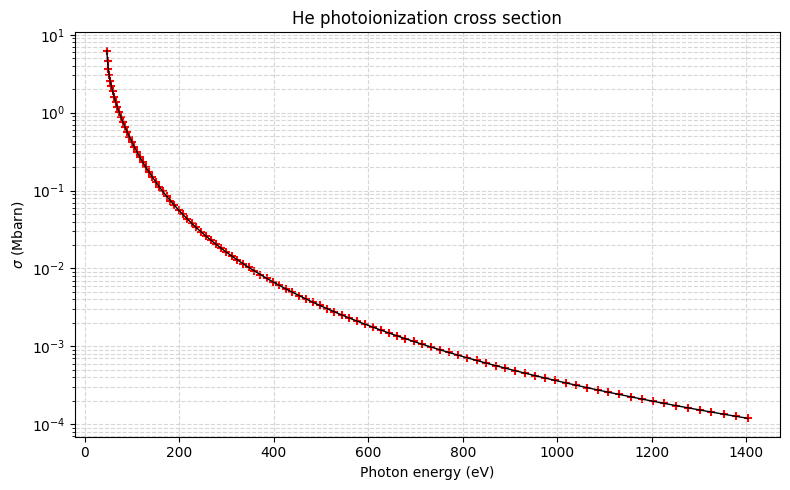

'\nk = 6\nu_cont = RK_continuum(k, Z=2, l=1, rho=rho_int, r=r_grid)\nR_cont = u_cont/r_grid\n\nPhE = 0.5 * k**2 - Efstion\nintegrand = R_init * R_cont * r_grid**3\n\ncutoff_idx = adaptive_cutoff(r_grid, integrand, threshold=1e-6)\nI = np.trapezoid(integrand[:cutoff_idx], r_grid[:cutoff_idx])\n\nsigma_k = to_Mbarn * alpha * PhE * (16/3) * np.pi**2 * I**2\nsigma.append(sigma_k)\nprint("this value is ok w:", PhE* 27.2114, " ",sigma_k)\npeV.append(PhE * 27.2114)\n'

In [6]:
r_grid = np.linspace(1e-5, 100.0, 100000)
dr = r_grid[1] - r_grid[0]
rho_int = interp1d(r_bd, rho_bd, kind='cubic', bounds_error=False, fill_value=0.0)(r_grid) # Use interp1d with fill_value=0.0 for safe extrapolation
rho_int = np.maximum(rho_int, 0.0) # Ensure density is non-negative

R_init = interp1d(r_bd, R_bd_scf, kind='cubic', bounds_error=False, fill_value=0.0)(r_grid)
R_init /= np.sqrt(np.trapz((r_grid*R_init)**2, r_grid))

# adaptative cutoff
def adaptive_cutoff(r, integrand, threshold=1e-6, window_fraction=0.005):
    abs_int = np.abs(integrand)
    max_val = np.max(abs_int)
    window = max(1, int(len(r) * window_fraction)) # Make window size a fraction of total points
    for i in range(len(r) - window):
        if np.all(abs_int[i:i+window] < threshold * max_val):
            return i
    return len(r)


# Continuum

def asymptotic_r(r, A, gamma, l, delta, k):
    return A * np.sqrt( 2 * k / np.pi ) * np.sin(
        r*k- gamma * np.log(2 * r * k ) - 0.5 * np.pi * l + delta
    )

def RK_continuum(k, Z, l, rho, r):

    V = build_effective_potential(Z, r, rho)
    Vint = interp1d(r, V, kind="cubic", fill_value="extrapolate")

    u0 = r[0] ** (l + 1)
    du0 = (l + 1) * r[0] ** l

    sol = solve_ivp(
        radial_eq,
        (r[0], r[-1]),
        [u0, du0],
        t_eval=r,
        method='RK45',
        rtol=1e-9,
        atol=1e-11,
        first_step=1e-8,
        args=(l, (k**2) / 2, Vint),
    )

    # Check if integration was successful
    if not sol.success:
        raise RuntimeError(f"Integration failed:  {sol.message}")

    u = sol.y[0]
    r_s = sol.t

    print(f"Integration produced {len(r_s)} points (requested {len(r)})")

    # Check if we got enough points
    if len(r_s) < 10:
        raise ValueError(f"solve_ivp returned only {len(r_s)} points. Check your differential equation and initial conditions.")


    fit_fraction = 0.30
    n_fit_points = int(fit_fraction * len(r_s))
    n_fit_points = max(200, n_fit_points)     # safety minimum
    n_fit_points = min(n_fit_points, len(r_s))

    r_fit = r_s[-n_fit_points:]
    u_fit = u[-n_fit_points:]
    print(f"Using {len(r_fit)} points for asymptotic fitting from r={r_fit[0]:.2f} to r={r_fit[-1]:.2f}")

    gamma = (Z-1) / k
    sigma_l_complex = sp_gamma(l + 1 + 1j * gamma)
    sigma_l = cmath.phase(sigma_l_complex)

    # Fitting
    p0 = [1.0, sigma_l]

    try:
        popt, _ = curve_fit(
            lambda r_s, A_fit, delta_fit: asymptotic_r(r_s, A_fit, gamma, l, delta_fit, k),
            r_fit,
            u_fit,
            p0=p0,
            maxfev=10000
        )
        A_fit, delta_fit = popt
    except Exception as e:
        print(f"Fitting failed: {e}")
        print(f"Number of fitting points: {len(r_fit)}")
        print(f"r_fit range: [{r_fit[0]}, {r_fit[-1]}]")
        print(f"u_fit range:  [{np.min(u_fit)}, {np.max(u_fit)}]")
        raise

    u_normalized = u /(A_fit)

    # Ensure delta_fit is in the canonical range [-pi, pi]
    delta_fit = (delta_fit + np.pi) % (2 * np.pi) - np.pi

    return u_normalized


# Photoionization cross section
Efstion = Eion  # He ionization energy in Hartree
alpha = 1 / 137.035999177
to_Mbarn = 28.00285
k_values = np.linspace(0.5, 10.0, 100)
sigma = []
peV = []

for k in k_values:
    u_cont = RK_continuum(k, Z=2, l=1, rho=rho_int, r=r_grid)
    R_cont = u_cont/r_grid

    PhE = 0.5 * k**2 - Efstion
    integrand = R_init * R_cont * r_grid**3
    # Use adaptive cutoff and the correctly defined integrand
    cutoff_idx = adaptive_cutoff(r_grid, integrand, threshold=1e-6)
    I = np.trapezoid(integrand[:cutoff_idx], r_grid[:cutoff_idx])

    sigma_k = to_Mbarn * alpha * PhE *(4/3) * np.pi**2 * (I/k)**2
    sigma.append(sigma_k)
    print("this value is ok w:", PhE* 27.2114, " ",sigma_k)
    peV.append(PhE * 27.2114)

# ======================================================
# Plot
# ======================================================
plt.figure(figsize=(8, 5))
plt.plot(peV, sigma, "k-", lw=1)
plt.scatter(peV, sigma, color="red", marker="+")
plt.yscale("log")
plt.xlabel("Photon energy (eV)")
plt.ylabel(r"$\sigma$ (Mbarn)")
plt.title("He photoionization cross section")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

'''
k = 6
u_cont = RK_continuum(k, Z=2, l=1, rho=rho_int, r=r_grid)
R_cont = u_cont/r_grid

PhE = 0.5 * k**2 - Efstion
integrand = R_init * R_cont * r_grid**3

cutoff_idx = adaptive_cutoff(r_grid, integrand, threshold=1e-6)
I = np.trapezoid(integrand[:cutoff_idx], r_grid[:cutoff_idx])

sigma_k = to_Mbarn * alpha * PhE * (16/3) * np.pi**2 * I**2
sigma.append(sigma_k)
print("this value is ok w:", PhE* 27.2114, " ",sigma_k)
peV.append(PhE * 27.2114)
'''

In [7]:
# Save Photon Energy (eV) and Sigma (Mbarn) to CSV for later use
from pathlib import Path
import numpy as np
import csv

# Expecting `peV` (photon energy in eV) and `sigma` (Mbarn) to exist from previous cells
energy = np.asarray(peV, dtype=float).ravel()
sigma_arr = np.asarray(sigma, dtype=float).ravel()

if energy.shape[0] != sigma_arr.shape[0]:
    raise ValueError(f"Mismatched lengths: energy={energy.shape[0]}, sigma={sigma_arr.shape[0]}")

out_path = Path("outputs") / "sigma_vs_photon_energy.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)

with out_path.open("w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["photon_energy_eV", "sigma_Mbarn"])  # header
    writer.writerows(zip(energy, sigma_arr))

print(f"Saved {energy.size} rows to {out_path}")

Saved 100 rows to outputs/sigma_vs_photon_energy.csv


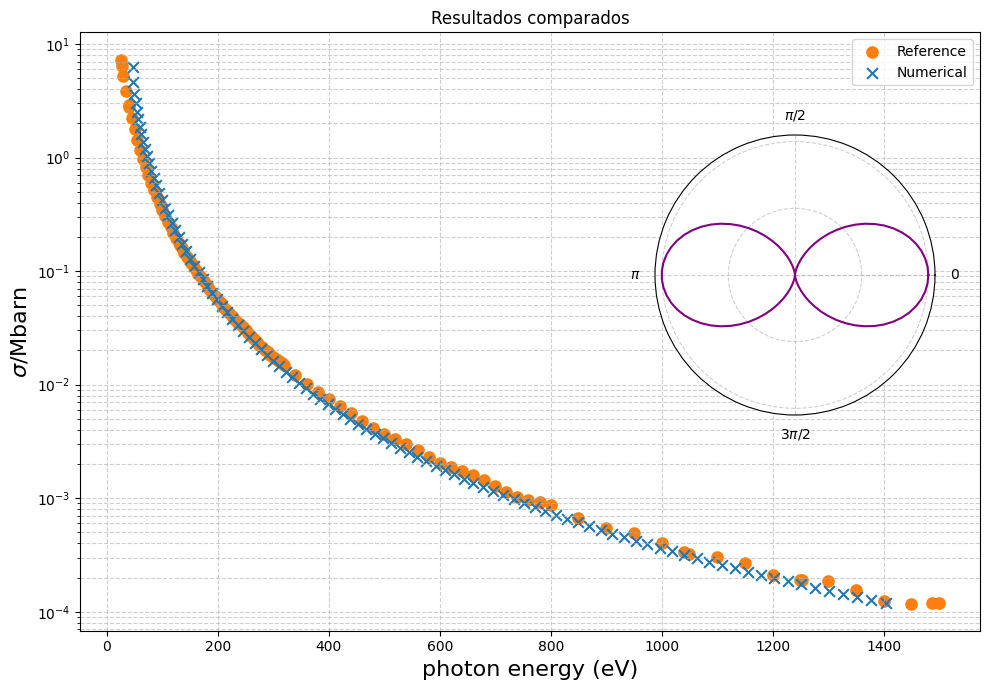

In [13]:
# Plot numerical data from saved CSV
import numpy as np
import matplotlib.pyplot as plt

# Load data saved earlier: headers are photon_energy_eV,sigma_Mbarn
data = np.genfromtxt("outputs/sigma_vs_photon_energy.csv", delimiter=",", names=True)
energy_csv = data["photon_energy_eV"]
sigma_csv = data["sigma_Mbarn"]

# Load reference data
fref = open("/content/he1s.txt", "r").readlines()
ref_energy = [float(line.split()[0]) for line in fref]
ref_cross_section = [float(line.split()[1]) for line in fref]

fig = plt.figure(figsize=(10, 7))
plt.scatter(ref_energy, ref_cross_section, color="tab:orange", s=65, label="Reference")
plt.scatter(energy_csv, sigma_csv, color="tab:blue", marker="x", s=60, label = "Numerical")


plt.yscale("log")
plt.xlabel("photon energy (eV)", fontsize=16)
plt.ylabel(r"$\sigma$/Mbarn", fontsize=16)
plt.title("Resultados comparados")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.tight_layout()

# Create inset plot as a polar plot
inset_ax = fig.add_axes([0.6, 0.4, 0.4, 0.4], polar=True) # [x0, y0, width, height] in figure coordinates, add polar=True

# Plot cosine squared in the inset (polar coordinates)
theta = np.linspace(0, 2*np.pi, 100)
r_values = np.cos(theta)**2
inset_ax.plot(theta, r_values, color='purple')

inset_ax.set_xticks(np.linspace(0, 2*np.pi, 5)) # Set ticks at 0, pi/2, pi, 3pi/2, 2pi
inset_ax.set_xticklabels([r'0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r' ']) # Label ticks
inset_ax.set_yticks([0.5, 1.0], labels=['', '']) # Set two radial ticks with empty labels
inset_ax.grid(True, ls='--', alpha=0.6)


plt.show()